In [ ]:
from google.colab import files
uploaded=files.upload()

KeyboardInterrupt: 

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving HAM10000_metadata.csv to HAM10000_metadata.csv


In [ ]:
import zipfile

zip_path = "/content/HAM1000subset.zip"
extract_path = "/content/HAM1000subset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)


Unzipped to: /content/HAM1000subset


Load metadata and filter for subset

In [ ]:
import pandas as pd
import os

metadata=pd.read_csv("/content/HAM10000_metadata.csv")

image_dir="/content/HAM1000subset/HAM1000subset"
image_files=set([f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.jpg')])

metadata_subset=metadata[metadata['image_id'].isin(image_files)]
print("Filtered metaddata shape:",metadata_subset.shape)

metadata_subset.head()

Filtered metaddata shape: (924, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
26,HAM_0002521,ISIC_0029291,bkl,histo,40.0,male,upper extremity
39,HAM_0003847,ISIC_0028560,bkl,histo,85.0,male,upper extremity
41,HAM_0000164,ISIC_0029161,bkl,histo,60.0,male,chest


Encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
metadata_subset['label']=le.fit_transform(metadata_subset['dx'])

class_mapping=dict(zip(le.classes_,le.transform(le.classes_)))
print("Label Encoding:",class_mapping)

Label Encoding: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}


<ipython-input-8-801241125>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_subset['label']=le.fit_transform(metadata_subset['dx'])


Load,Resize images & prepare arrays

In [ ]:
import numpy as np
from PIL import Image
from tqdm import tqdm

IMG_SIZE=64
X=[]
y=[]

for idx,row in tqdm(metadata_subset.iterrows(),total=len(metadata_subset)):
  img_path=os.path.join(image_dir,row['image_id']+".jpg")
  try:
    img=Image.open(img_path).resize((IMG_SIZE,IMG_SIZE))
    X.append(np.array(img))
    y.append(row['label'])
  except:
    print("Error loading:",img_path)

X=np.array(X)
y=np.array(y)

print("X shape:",X.shape)
print("y shape:",y.shape)

100%|██████████| 924/924 [00:06<00:00, 134.14it/s]

X shape: (924, 64, 64, 3)
y shape: (924,)


Train-Test split & Normalization

In [ ]:
from sklearn.model_selection import train_test_split

X=X/255.0

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

print("Train shape:",X_train.shape)
print("Test shape:",X_test.shape)


Train shape: (739, 64, 64, 3)
Test shape: (185, 64, 64, 3)


Build and Train a CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),
    MaxPooling2D(2,2),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(len(class_mapping),activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,055 (6.20 MB)

 Trainable params: 1,626,055 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [ ]:
history=model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.5579 - loss: 1.5155 - val_accuracy: 0.6811 - val_loss: 1.0559
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6939 - loss: 1.1130 - val_accuracy: 0.6811 - val_loss: 1.0161
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6774 - loss: 1.1105 - val_accuracy: 0.6811 - val_loss: 1.0095
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6883 - loss: 1.1444 - val_accuracy: 0.6811 - val_loss: 0.9071
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6925 - loss: 0.9868 - val_accuracy: 0.6811 - val_loss: 0.9466
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6580 - loss: 1.0589 - val_accuracy: 0.6811 - val_loss: 0.8789
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6717 - loss: 1.0226 - val_accuracy: 0.6811 - val_loss: 0.8444
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6839 - loss: 0.9537 - val_accuracy: 0.6811 - val_los

Plot Accuracy and Loss Curves

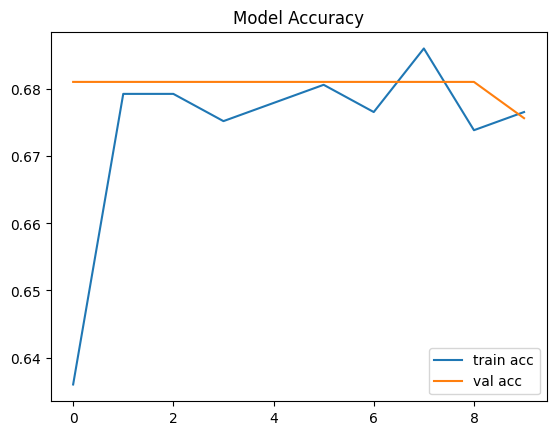

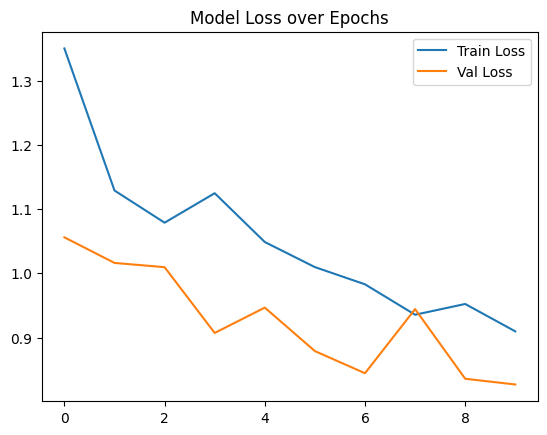

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title("Model Loss over Epochs")
plt.legend()
plt.show()

Evaluate the model

In [ ]:
test_loss,test_acc=model.evaluate(X_test,y_test)
print("Test Accuracy:",test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6728 - loss: 0.8409 
Test Accuracy: 0.6756756901741028


Predict on 5 random test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


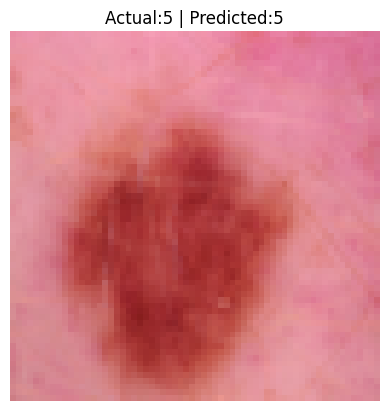

Prediction confidence:
0:0.00
1:0.00
2:0.00
3:0.00
4:0.02
5:0.97
6:0.00
________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


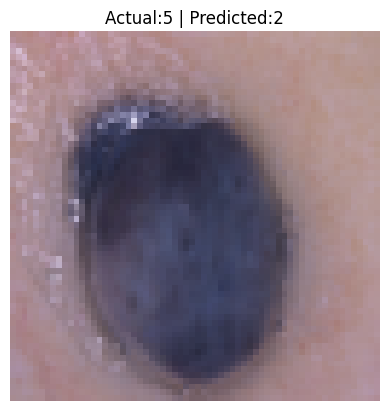

Prediction confidence:
0:0.09
1:0.18
2:0.25
3:0.04
4:0.18
5:0.22
6:0.04
________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


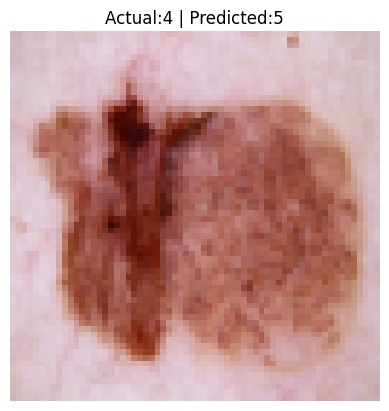

Prediction confidence:
0:0.02
1:0.02
2:0.20
3:0.00
4:0.20
5:0.55
6:0.00
________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


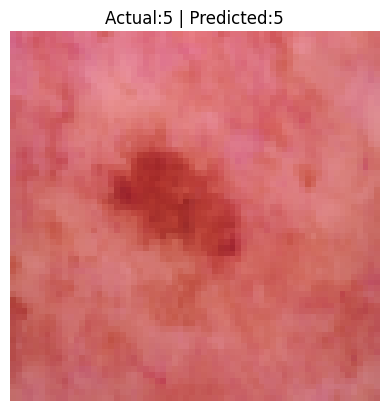

Prediction confidence:
0:0.00
1:0.00
2:0.01
3:0.00
4:0.02
5:0.97
6:0.00
________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


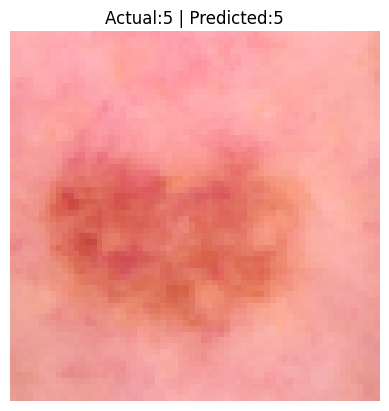

Prediction confidence:
0:0.01
1:0.02
2:0.10
3:0.00
4:0.10
5:0.77
6:0.00
________________________________________


In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
label_encoder.fit(metadata_subset['label'])

indices=random.sample(range(len(X_test)),5)

for i in indices:
  img=X_test[i]
  label=y_test[i]

  prediction=model.predict(np.expand_dims(img,axis=0))
  predicted_label=np.argmax(prediction)

  predicted_class=label_encoder.inverse_transform([predicted_label])[0]
  actual_class=label_encoder.inverse_transform([label])[0]

  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Actual:{actual_class} | Predicted:{predicted_class}")
  plt.show()

  print("Prediction confidence:")
  for j,prob in enumerate(prediction[0]):
    class_name=label_encoder.inverse_transform([j])[0]
    print(f"{class_name}:{prob:.2f}")
  print("_"*40)

Testing on an image random manually

In [23]:
from google.colab import files
uploaded=files.upload()

Saving ISIC_0033688.jpg to ISIC_0033688.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


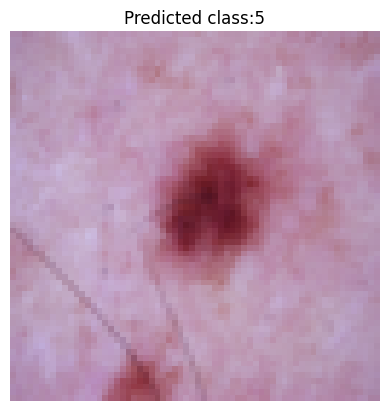

Prediction confidence:
0:0.01
1:0.02
2:0.07
3:0.00
4:0.10
5:0.79
6:0.00


In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for filename in uploaded.keys():

  img=Image.open(filename).resize((64,64))
  img_array=np.array(img)/255.0

  if len(img_array.shape)==2:
    img_array=np.stack((img_array,)*3,axis=1)

  prediction=model.predict(np.expand_dims(img_array,axis=0))
  predicted_label=np.argmax(prediction)
  predicted_class=label_encoder.inverse_transform([predicted_label])[0]

  plt.imshow(img_array)
  plt.axis('off')
  plt.title(f"Predicted class:{predicted_class}")
  plt.show()

  print("Prediction confidence:")
  for i , prob in enumerate(prediction[0]):
    name=label_encoder.inverse_transform([i])[0]
    print(f"{name}:{prob:.2f}")

